# Setup for a new code project

**What ?** 

**Why ?** 

**How ?** 


<img src="https://lh3.googleusercontent.com/d/1Lsvm6GjRzodIgEi640Ev4sBDDWutHzBs" alt="texto_alternativo" width="300" align="left">

## Import Libraries

In [137]:
import pandas as pd
import numpy as np

import yfinance as yf
import os

In [138]:
script_directory = os.getcwd() #getting the script directory path
directory_path = os.path.join(script_directory,'IBOVDia_22-07-24.csv') # IBRX100 index composition downloaded from B3 website

In [139]:
# reading ibovespa composition
df_ibov = pd.read_csv(os.path.join(script_directory,'IBOVDia_22-07-24.csv'), 
                      encoding = 'cp1252',
                      sep = ';',
                      skiprows=1,
                      skipfooter=2,
                      index_col = False,
                      thousands='.',
                      decimal=',',
                      dtype={'Qtde. Teórica': float,  'Part. (%)':float})

df_ibov['tickers'] = df_ibov['Código']+'.SA'

df_ibov.head()

C:\Users\lucas\AppData\Local\Temp\ipykernel_19660\3800829741.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_ibov = pd.read_csv(os.path.join(script_directory,'IBOVDia_22-07-24.csv'),


,Código,Ação,Tipo,Qtde. Teórica,Part. (%),tickers
0,RRRP3,3R PETROLEUM,ON NM,2.384417e+08,0.309,RRRP3.SA
1,ALOS3,ALLOS,ON NM,5.326166e+08,0.551,ALOS3.SA
2,ALPA4,ALPARGATAS,PN N1,1.663620e+08,0.070,ALPA4.SA
3,ABEV3,AMBEV S/A,ON ATZ,4.394246e+09,2.458,ABEV3.SA
4,ARZZ3,AREZZO CO,ON ED NM,6.230589e+07,0.155,ARZZ3.SA


In [140]:
start_date = '2023-07-15'
end_date = '2024-07-15'
data = yf.download(df_ibov['tickers'].to_list(), start = start_date, end = end_date)['Adj Close']
data['time'] = data.index


data1 = pd.melt(data, id_vars = ['time'], var_name = 'asset', value_name = 'price') # change dataframe wide to long

data1['returns'] = data1.groupby('asset')['price'].pct_change() #calculating daily returns 

data1.head()

[*********************100%%**********************]  86 of 86 completed


,time,asset,price,returns
0,2023-07-17,ABEV3.SA,14.083839,NaN
1,2023-07-18,ABEV3.SA,13.941291,-0.010121
2,2023-07-19,ABEV3.SA,13.903277,-0.002727
3,2023-07-20,ABEV3.SA,14.178872,0.019822
4,2023-07-21,ABEV3.SA,14.539996,0.025469


### Calculating pandas EWM method

In [141]:

data3 = data1.groupby('asset')['returns'].ewm(span = 252 , adjust=False).std().to_frame().reset_index(level = 0).rename(columns = {'returns':'std_ewma'}) 

data4 = data3.groupby('asset')['std_ewma'].sum().to_frame().reset_index(level = 0).sort_values(by = ['std_ewma']) 

data4['std_ewma_anual'] = data4['std_ewma']* np.sqrt(252) #annualized


percentiles = [0, 0.33, 0.66, 1]

# Use pd.qcut to split the data into 3 parts and assign the part labels
data4['percentile_group'] = pd.qcut(data4['std_ewma_anual'], q=percentiles, labels=["Low", "Medium", "High"])
data4.reset_index(drop = True, inplace = True)

data4.head(50)

,asset,std_ewma,std_ewma_anual,percentile_group
0,TAEE11.SA,1.652670,26.235317,Low
1,CPFE3.SA,2.248234,35.689607,Low
2,EGIE3.SA,2.253965,35.780577,Low
3,ALOS3.SA,2.334193,37.054169,Low
4,ITSA4.SA,2.381762,37.809292,Low
5,BBAS3.SA,2.582923,41.002627,Low
6,EQTL3.SA,2.605553,41.361873,Low
7,KLBN11.SA,2.726458,43.281185,Low
8,BBSE3.SA,2.749195,43.642121,Low
9,SANB11.SA,2.825068,44.846562,Low


In [142]:
df_lvol11 = pd.read_excel(os.path.join(script_directory,'Cesta LVOL11 20240722.xlsx'),
                         skiprows=10)  # reading LCOL11 official tickers composition

data4['Ativo'] = data4['asset'].str.replace('.SA','',regex = False)

df_lvol11 = pd.merge(df_lvol11,data4[['Ativo','percentile_group']], on = 'Ativo', how = 'left')
df_lvol11

,Ativo,Quantidade,Valor de Abertura (R$),Participação no Total da Cesta (%),percentile_group
0,ABEV3,15758,184842.27,3.736,Low
1,BBAS3,6543,177371.40,3.585,Low
2,BBSE3,6770,230854.93,4.666,Low
3,BRAP4,7765,146993.14,2.971,Low
4,CCRO3,13021,161588.56,3.266,Low
5,CPFE3,5820,191373.10,3.868,Low
6,CPLE6,17412,175342.88,3.544,Medium
7,EGIE3,4801,218931.22,4.425,Low
8,ENGI11,3301,152831.31,3.089,Low
9,EQTL3,5808,188701.40,3.814,Low


#### Dealing with SQLite database

In [ ]:
import sqlite3

# write the dataframe into the SQLite database
conn = sqlite3.connect('D:/finance_data/finance_database.db')

df.to_sql('B3_companies_sectors',conn,if_exists='replace',index=False)

In [ ]:
# Reading all table names from sqlite_master database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table in tables: #print names
    print(table[0])

In [1]:
# delete tables
import sqlite3
# Connect to the SQLite database
conn = sqlite3.connect('D:/finance_data/finance_database.db')
cursor = conn.cursor()

# List of tables you want to delete
tables_to_delete = ['B3_historical_quotes']


# Loop through the list and delete each table
for table in tables_to_delete:
    cursor.execute(f"DROP TABLE IF EXISTS {table}")

# Commit the changes
conn.commit()

# Close the connection
conn.close()


## Scrapping PDF

##### finding a string coordinations on a page

In [ ]:

import pdfplumber

# Function to find the coordinates of a specific string
def find_string_coordinates(pdf_path, page_number, search_string):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_number]
        words = page.extract_words()
        
        for word in words:
            if word['text'] == search_string:
                # Extracting coordinates
                x0, y0, x1, y1 = word['x0'], word['top'], word['x1'], word['bottom']
                return (x0, y0, x1, y1)
                
    return None

# Specify the PDF path, page number (0-indexed), and search string
page_number = initial_page_tag-1  # First page
search_string = 'Aberto'

# Find and print the coordinates
coordinates = find_string_coordinates(pdf_path, page_number, search_string)
if coordinates:
    print(f"Coordinates of '{search_string}': {coordinates}")
else:
    print(f"String '{search_string}' not found on page {page_number + 1}")
    

##### Looking for table vertical columns lines in a pdf page

Site para seperadar apenas uma página do PDF
https://www.ilovepdf.com/download/pf0sgy357k4cypf1xw9jw0qyg4d728xA3hvd7mqhdkkA41pllA44087f3Abgsdgt7w78tgpkk6lnqtqr6xdxzvbn30yc224lzp7z70c7mzdptyg0r8q9jl6lg23489A6jq6zA6tdrzcrr39dkv48q07bfh40kxmdw9103s350ym5prrb1g8q/36

In [ ]:
'C:\\Users\\lucas\\OneDrive\\CM_Explorer\\data_scraping\\B3_Daily_market_bulletin\\temp_file\\'

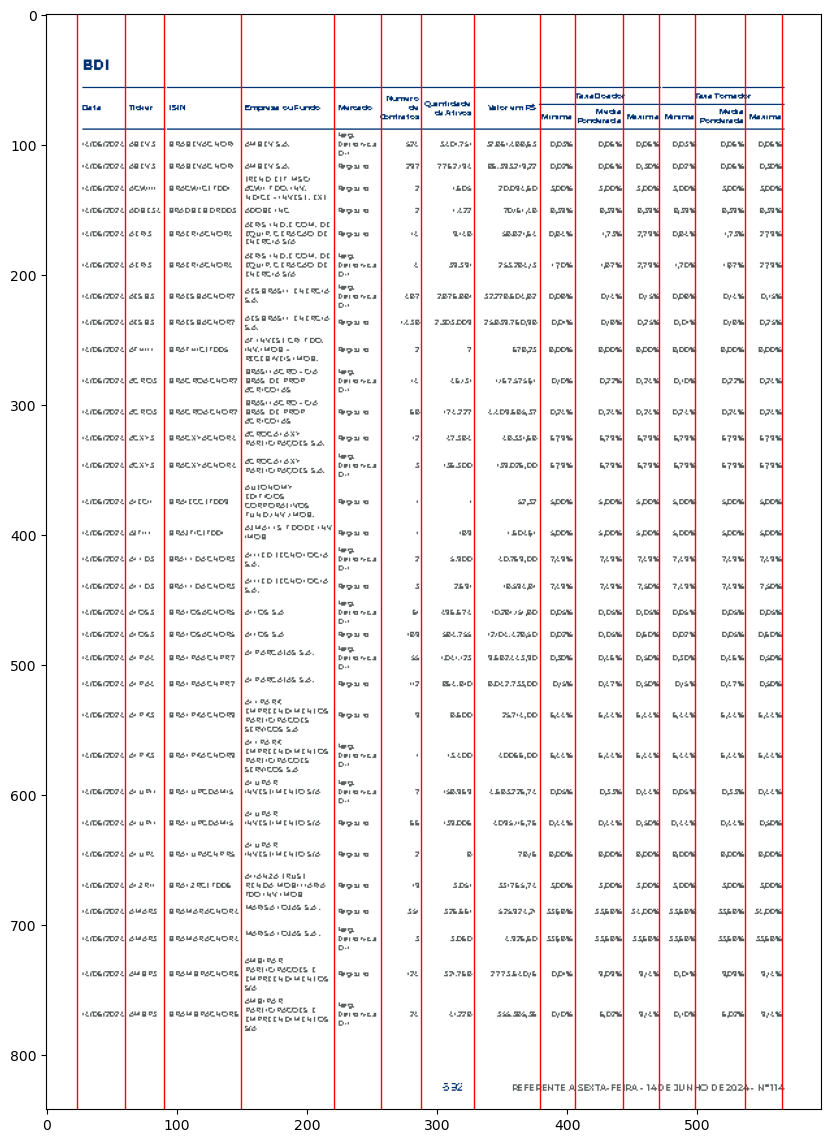

In [15]:
import pdfplumber
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to draw vertical lines on the page
def draw_vertical_lines(page, vertical_lines):
    plt.figure(figsize=(10, 15))
    plt.imshow(page.to_image().original, cmap='gray')

    for x in vertical_lines:
        plt.axvline(x=x, color='red', linewidth=1)

    plt.show()

# Open the PDF file
pdf_path = 'C:\\Users\\lucas\\OneDrive\\CM_Explorer\\data_scraping\\B3_Daily_market_bulletin\\temp_file\\extract_page_emprestimo_registrado.pdf'
with pdfplumber.open(pdf_path) as pdf:
    # Specify the page number
    page_number = 0  # change this to the page number where your table is located
    page = pdf.pages[page_number]

    # Define the vertical lines positions (coordinates)
    vertical_lines = [23,60,90,149,221,257,288,328,379,406,443,471,498,537,565]   # Example x-coordinates for vertical lines

    # Draw the vertical lines on the page
    draw_vertical_lines(page, vertical_lines)
